__Purpose:__ Test the performance of already trained decoders to see if they continue to achieve the best performance, and to see if personalization is necessary/possible.  Ideally, this NB should show that the outputs of previous training rounds will maintain their high performance.  I am ambivalent about whether or not we would expect any further improvement over training.

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

#import seaborn as sns
#from presentation_sns_config import *

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

# Verify Federated Set Up Runs

In [3]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

In [4]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

# No-FL Case
## Random Inits

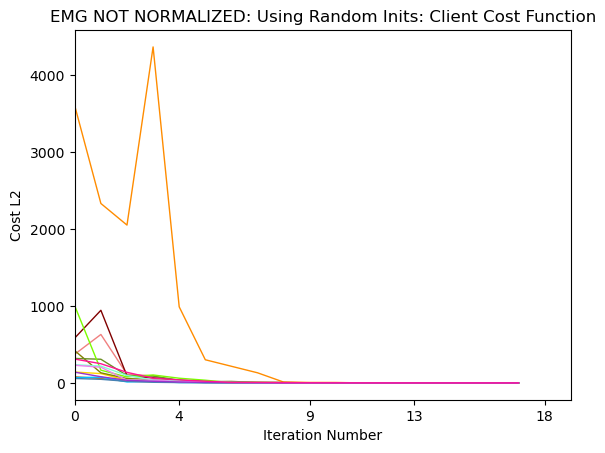

In [24]:
user_nofl_rand_init = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, set_alphaF_zero=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_nofl_rand_init = Server(-1, D_0, 'NoFL', user_nofl_rand_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_nofl_rand_init.execute_FL_loop()
    
condensed_external_plotting(user_nofl_rand_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='EMG NOT NORMALIZED: Using Random Inits: Client Cost Function')

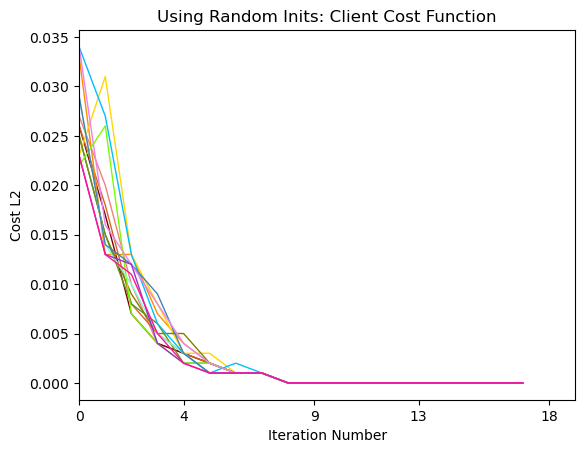

In [23]:
user_nofl_rand_init = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, set_alphaF_zero=True, normalize_EMG=True, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_nofl_rand_init = Server(-1, D_0, 'NoFL', user_nofl_rand_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_nofl_rand_init.execute_FL_loop()
    
condensed_external_plotting(user_nofl_rand_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using Random Inits: Client Cost Function')

## CPHS Inits

In [6]:
avg_cond0_init = cond0_init_decs[0]
for i in range(1, 14):
    avg_cond0_init += cond0_init_decs[i]
avg_cond0_init /= 14

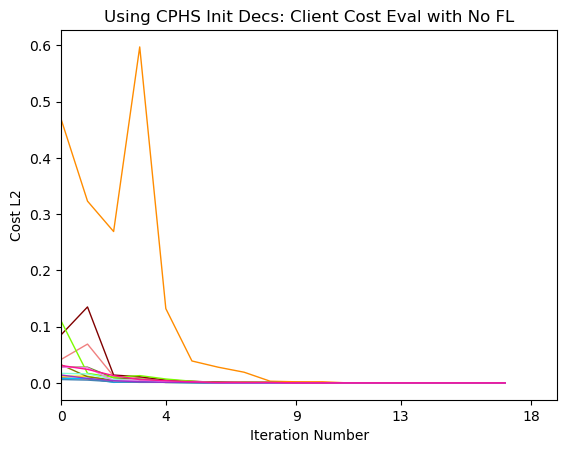

In [7]:
user_c0_no_fl_w_cphs_init = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, set_alphaF_zero=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_w_cphs_init = Server(-1, avg_cond0_init, 'NoFL', user_c0_no_fl_w_cphs_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_w_cphs_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

## Using Final Client Decs as Client Inits

In [8]:
avg_client_init = user_c0_no_fl_w_cphs_init[0].w
for i in range(1, 14):
    avg_client_init += user_c0_no_fl_w_cphs_init[i].w
avg_client_init /= 14

In [29]:
avg_client_init

array([[ 7.64869210e-04,  1.49516210e-03, -9.77182039e-05,
        -1.14798861e-03,  4.35432543e-04, -7.91390205e-04,
        -1.28906226e-03, -5.23368256e-04,  1.05401623e-03,
         7.96122797e-05, -2.61130702e-03,  2.13367268e-04,
         2.61741635e-03, -1.58686784e-03,  4.10078561e-03,
         1.26129855e-04, -7.49113556e-04, -5.08874221e-04,
        -1.87162802e-03,  1.05487469e-03, -1.25238489e-03,
        -1.85726464e-03, -4.24887337e-04,  4.22494481e-04,
         1.28204125e-03,  1.86871418e-04, -2.64478606e-03,
         1.66165954e-03, -8.58968774e-04,  1.05225749e-03,
        -1.62111369e-04, -8.56154148e-04,  4.77888549e-04,
         1.10260337e-03,  9.55243340e-04, -1.36521888e-03,
         6.85709101e-04, -1.55530944e-03,  3.53243827e-04,
        -1.39863587e-03,  2.55271819e-04, -4.88614233e-04,
         2.78753099e-04, -6.78111447e-04,  6.70234515e-05,
        -5.71507136e-04, -8.40118076e-04,  2.51190623e-03,
         9.58265215e-04, -8.16223676e-04,  1.96497802e-0

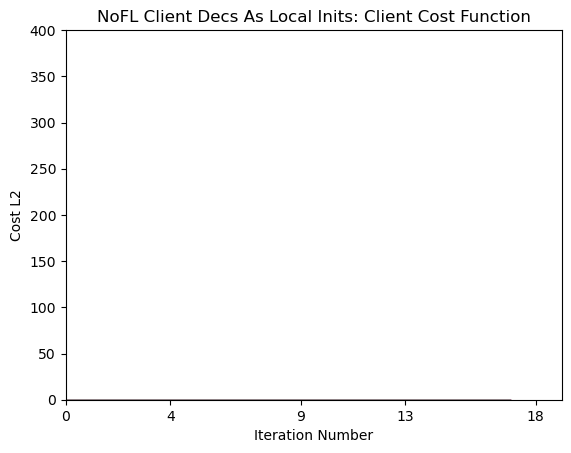

In [9]:
user_c0_no_fl_wclient_init = [Client(i, user_c0_no_fl_w_cphs_init[i].w, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, set_alphaF_zero=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_wclient_init = Server(-1, avg_client_init, 'NoFL', user_c0_no_fl_wclient_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_wclient_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_no_fl_wclient_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, ylim_max=400, custom_title='NoFL Client Decs As Local Inits: Client Cost Function')

In [27]:
user_c0_no_fl_wclient_init[0].local_error_log

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

How is the training error zero... I guess I should add a test run and be plotting test error...

# Federated Learning
## 1 Scipy Step, 500 Iterations
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 145, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 279, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 432, 75)



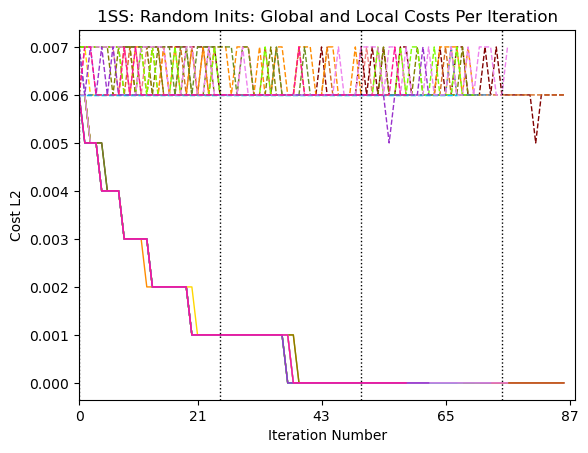

In [10]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 500
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1SS: Random Inits: Global and Local Costs Per Iteration')

In [11]:
#condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')

## Using Final Client Decs as Local Inits
> Local error log is all 0s for some reason.......

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 163, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 382, 50)



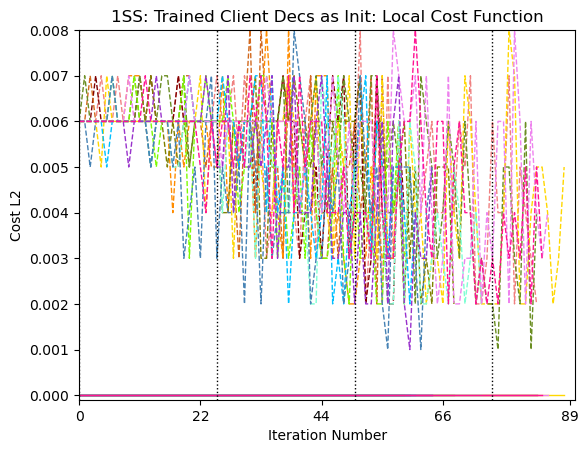

In [12]:
user_c0_1ScipyStep_wclient_init = [Client(i, user_c0_1ScipyStep[i].w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_wclient_init = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_wclient_init)

for i in range(big_loop_iters):
    global_model_1scipystep_wclient_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_wclient_init, 'local', ylim_min=-0.0001, ylim_max=0.008, custom_title='1SS: Trained Client Decs as Init: Local Cost Function')

## Using Final Global Model as Client Init for All

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 236, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 462, 50)



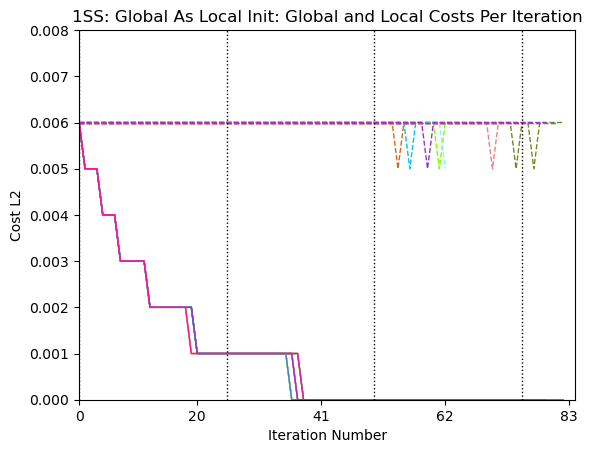

In [13]:
user_c0_1ScipyStep_wglobal_init = [Client(i, global_model_1scipystep.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_wglobal_init = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_wglobal_init)

for i in range(big_loop_iters):
    global_model_1scipystep_wglobal_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_wglobal_init, 'local', ylim_max=0.008, custom_title='1SS: Global As Local Init: Global and Local Costs Per Iteration')

## Using Final Global Model as Both Init for All
> Global model also set to prev final global

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 154, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 347, 50)



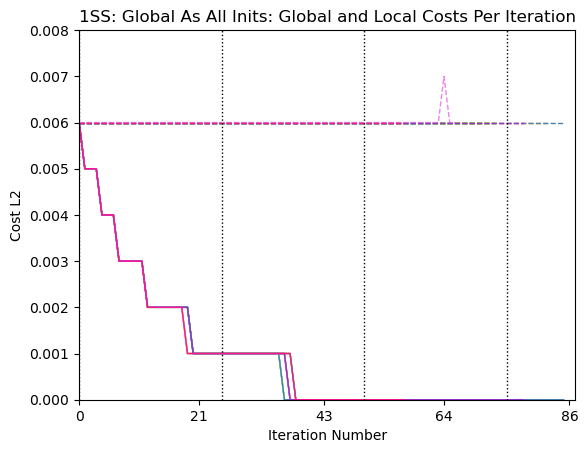

In [14]:
user_c0_1ScipyStep_wglobalx2_init = [Client(i, global_model_1scipystep.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_wglobalx2_init = Server(1, global_model_1scipystep.w, 'FedAvg', user_c0_1ScipyStep_wglobalx2_init)

for i in range(big_loop_iters):
    global_model_1scipystep_wglobalx2_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_wglobalx2_init, 'local', ylim_max=0.008, custom_title='1SS: Global As All Inits: Global and Local Costs Per Iteration')

# Aggregated NoFL Plot

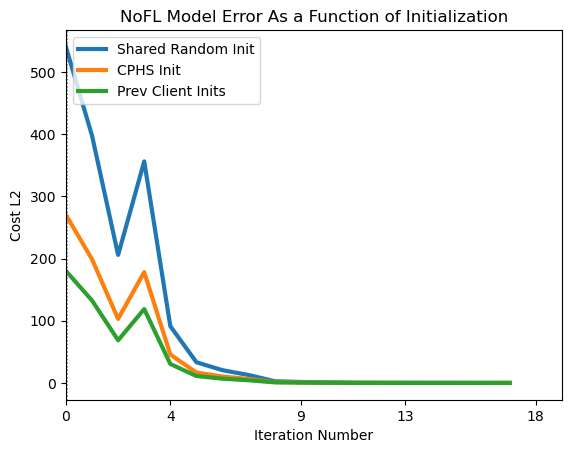

In [15]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_w_cphs_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'CPHS Init', 'Prev Client Inits'], input_linewidth=3, my_legend_loc='upper left', local_error=True, global_error=False, custom_title='NoFL Model Error As a Function of Initialization')

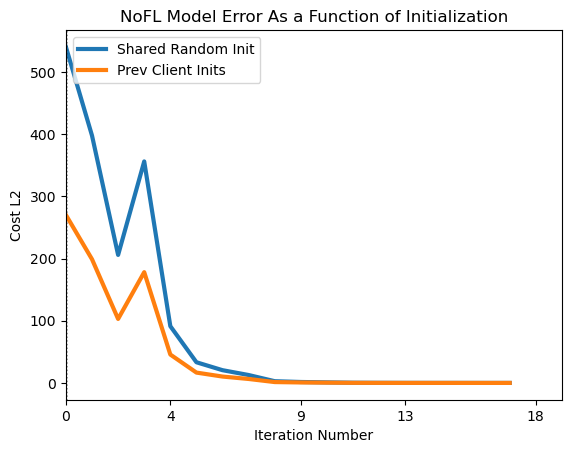

In [16]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'Prev Client Inits'], input_linewidth=3, my_legend_loc='upper left', local_error=True, global_error=False, custom_title='NoFL Model Error As a Function of Initialization')

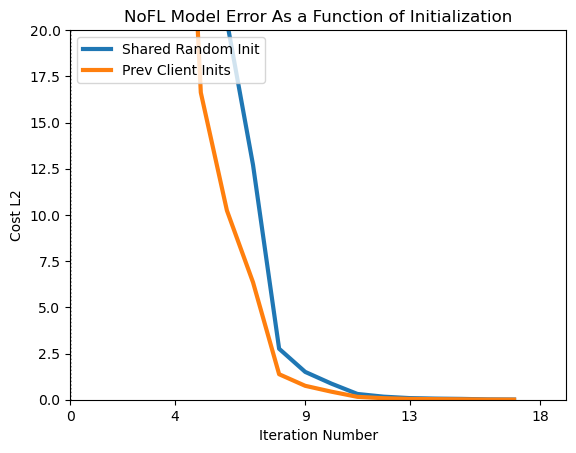

In [17]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'Prev Client Inits'], input_linewidth=3, my_legend_loc='upper left', local_error=True, global_error=False, ylim_min=0, ylim_max=20, custom_title='NoFL Model Error As a Function of Initialization')

# Aggregated FL Plot

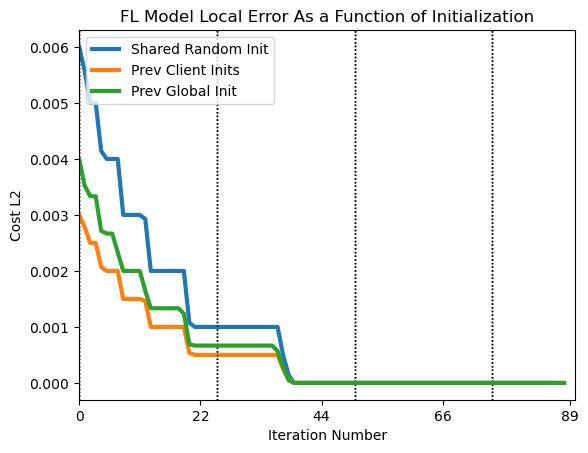

In [18]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Shared Random Init', 'Prev Client Inits', 'Prev Global Init'], input_linewidth=3, my_legend_loc='upper left', local_error=True, global_error=False, custom_title='FL Model Local Error As a Function of Initialization')

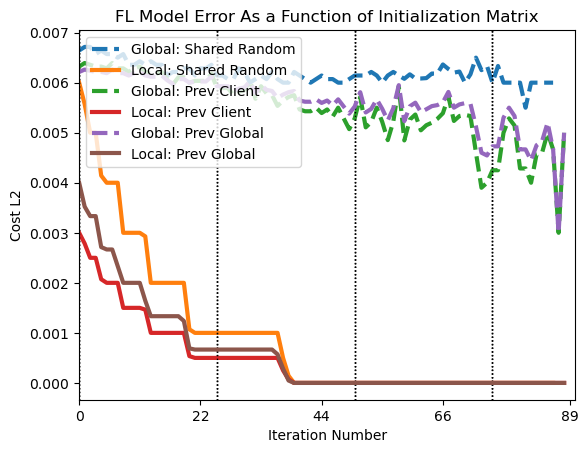

In [19]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Global: Shared Random', 'Local: Shared Random', 'Global: Prev Client', 'Local: Prev Client', 'Global: Prev Global', 'Local: Prev Global'], input_linewidth=3, my_legend_loc='upper left', local_error=True, global_error=True, custom_title='FL Model Error As a Function of Initialization Matrix')

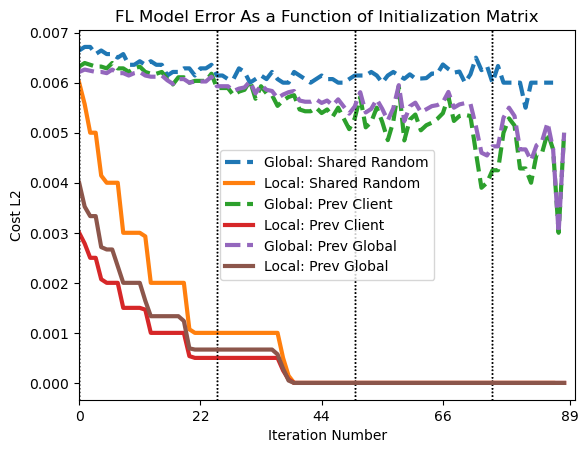

In [20]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Global: Shared Random', 'Local: Shared Random', 'Global: Prev Client', 'Local: Prev Client', 'Global: Prev Global', 'Local: Prev Global'], input_linewidth=3, local_error=True, global_error=True, custom_title='FL Model Error As a Function of Initialization Matrix')

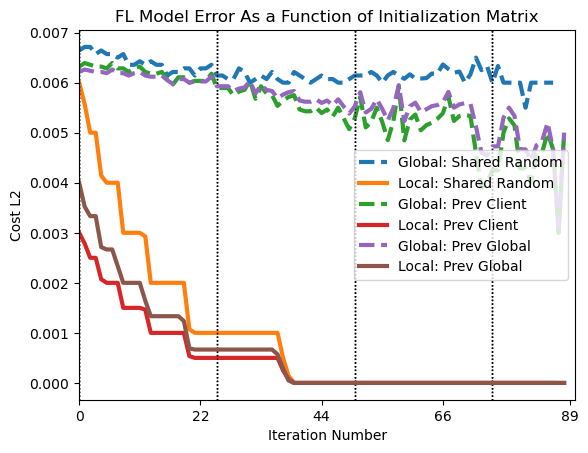

In [21]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Global: Shared Random', 'Local: Shared Random', 'Global: Prev Client', 'Local: Prev Client', 'Global: Prev Global', 'Local: Prev Global'], input_linewidth=3, local_error=True, global_error=True, my_legend_loc='center right', custom_title='FL Model Error As a Function of Initialization Matrix')

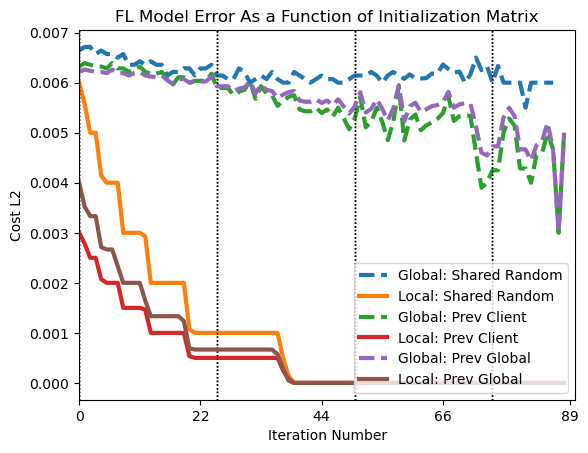

In [22]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Global: Shared Random', 'Local: Shared Random', 'Global: Prev Client', 'Local: Prev Client', 'Global: Prev Global', 'Local: Prev Global'], input_linewidth=3, local_error=True, global_error=True, my_legend_loc='lower right', custom_title='FL Model Error As a Function of Initialization Matrix')